In [1]:
import numpy as np
import pandas as pd

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, accuracy_score, balanced_accuracy_score, matthews_corrcoef,
    classification_report, confusion_matrix, log_loss
)
import plotly.graph_objects as go
from cassandra.cluster import Cluster
from datetime import datetime

In [2]:
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()
session.set_keyspace('data_stock')

eps pe pbv percentyield marketcap


ทำไมตั้งแบบนี้

EPS>0 = บริษัทมีกำไร (คุณภาพพื้นฐานขั้นต่ำ)

P/E 8–25 = กรองถูก/แพงเกินไป (ค่า default ทั่วไป—ปรับได้ตามอุตสาหกรรม)

P/BV 0.8–2.5 = ไม่ต่ำกว่าทุนมากเกิน (เสี่ยง) และไม่แพงเวอร์

Dividend Yield ≥ 3% (≤ 20%) = ให้ผลตอบแทนเงินสดพอเหมาะ (กัน outlier yield สูงผิดปกติ)

Quantile mode ใช้สัดส่วนภายในชุดข้อมูล → ดีสำหรับเปรียบเทียบ “สัมพัทธ์” ในตลาด/อุตสาหกรรมเดียวกัน

ถ้าต้องการ “น้ำหนัก” ไม่เท่ากัน (เช่นให้ EPS/PE หนักกว่า PBV/Yield) บอกได้ ผมปรับให้เป็น weighted score ได้เลย เช่น EPS/PE = 2 คะแนน, อีกสองตัว=1 คะแนน แล้วค่อยแปลงเป็น A–E ตามสัดส่วนคะแนนครับ

a: แรงมาก/overbought — Close ≥ EMA5 และ RSI ≥ 70

b: ขาขึ้นชัด — Close ≥ EMA35 และ EMA35 ≥ EMA89

c: Sideways เหนือ EMA89 — Close ≥ EMA89 และแถบ EMA ระยะสั้น (5/15/35/89) แคบ: (max-min)/mean ≤ band_pct (ค่าเริ่ม 1.5%)

d: ขาลง — Close < EMA89 และ Close < EMA200 และ EMA89 < EMA200

e: Crash — ลำดับลดหลั่นแรง Close < EMA5 < EMA15 < EMA35 < EMA89 < EMA200 และ RSI ≤ 30

In [3]:
rows_fin = session.execute("""
    SELECT symbol,close, pe, pbv, dividendyield,marketcap,bvps FROM smartset_finan_data ALLOW FILTERING
""")
df_financial = pd.DataFrame(rows_fin, columns=["symbol","close","pe","pbv","dividendyield","marketcap","bvps"])
df_financial = df_financial.dropna()

In [4]:
rows_price = session.execute("""
    SELECT symbol, time, close_price AS close_price FROM candlestick_data ALLOW FILTERING
""")
df_price = pd.DataFrame(rows_price, columns=['symbol', 'time', 'close_price'])
df_price['time'] = pd.to_datetime(df_price['time'])
df_price = df_price.sort_values(['symbol', 'time'])

In [5]:
df_financial.head()

,symbol,close,pe,pbv,dividendyield,marketcap,bvps
6,TPCH,2.92,8.13,0.35,13.53,1.171504e+09,8.25
10,POLY,6.8,12.55,2.43,6.62,3.060000e+09,2.80
12,VCOM,2.86,8.63,1.45,10.49,8.780349e+08,1.97
23,JDF,1.68,12.17,1.31,4.76,1.008000e+09,1.28
34,SUSCO,2.58,7.93,0.54,8.11,2.580000e+09,4.74


In [6]:
df_price.head()

,symbol,time,close_price
362761,24CS,2022-10-03,10.20
362762,24CS,2022-10-04,7.15
362763,24CS,2022-10-05,5.15
362764,24CS,2022-10-06,5.20
362765,24CS,2022-10-07,5.00


In [7]:
df_price.columns

Index(['symbol', 'time', 'close_price'], dtype='object')

In [8]:
print("Total unique symbols:", df_price['symbol'].nunique())
print("Total unique symbols:", df_financial['symbol'].nunique())

Total unique symbols: 912
Total unique symbols: 518


In [9]:
# ✅ กรองเฉพาะ symbol ที่มีข้อมูล financial
df_price = df_price[df_price['symbol'].isin(df_financial['symbol'])].reset_index(drop=True)

print("จำนวนข้อมูลราคา (df_price):", len(df_price))
print("จำนวนข้อมูล financial (df_financial):", len(df_financial))

# ตรวจสอบอีกครั้งว่าสัญลักษณ์ที่เหลือใน df_price มีใน df_financial ครบ
missing_symbols = set(df_price['symbol']) - set(df_financial['symbol'])
print("symbol ที่หาย:", missing_symbols)  # ควรจะว่าง set()


จำนวนข้อมูลราคา (df_price): 337130
จำนวนข้อมูล financial (df_financial): 518
symbol ที่หาย: set()


In [10]:
print("Total unique symbols:", df_price['symbol'].nunique())
print("Total unique symbols:", df_financial['symbol'].nunique())

Total unique symbols: 510
Total unique symbols: 518


In [11]:
symbols = sorted(df_price['symbol'].unique())
print(symbols)


['2S', 'A5', 'AAI', 'ACG', 'ADB', 'ADD', 'ADVANC', 'ADVICE', 'AEONTS', 'AF', 'AH', 'AHC', 'AI', 'AIE', 'AIT', 'AKP', 'AKR', 'ALLA', 'ALUCON', 'AMARC', 'AMARIN', 'AMATA', 'AMATAV', 'ANI', 'AOT', 'AP', 'APCO', 'APO', 'APP', 'APURE', 'ARIP', 'ARROW', 'ASEFA', 'ASIA', 'ASIAN', 'ASIMAR', 'ASK', 'ASP', 'ATP30', 'AU', 'AUCT', 'AURA', 'AWC', 'AYUD', 'BA', 'BAFS', 'BAM', 'BAY', 'BBGI', 'BBIK', 'BBL', 'BC', 'BCH', 'BCT', 'BDMS', 'BE8', 'BEC', 'BEM', 'BGC', 'BGRIM', 'BH', 'BIG', 'BIS', 'BIZ', 'BJC', 'BKD', 'BKGI', 'BKIH', 'BLA', 'BLAND', 'BLC', 'BM', 'BOL', 'BPP', 'BPS', 'BR', 'BRI', 'BRR', 'BTG', 'BTNC', 'BUI', 'BVG', 'CBG', 'CCET', 'CCP', 'CENTEL', 'CEYE', 'CH', 'CHAO', 'CHASE', 'CHAYO', 'CHG', 'CIVIL', 'CK', 'CKP', 'CM', 'CMAN', 'CMR', 'CNT', 'COCOCO', 'COLOR', 'COM7', 'CPALL', 'CPAXT', 'CPF', 'CPH', 'CPI', 'CPN', 'CPR', 'CPT', 'CPW', 'CRC', 'CREDIT', 'CSC', 'CSS', 'D', 'DCC', 'DCON', 'DDD', 'DELTA', 'DEXON', 'DITTO', 'DMT', 'DOHOME', 'DRT', 'DTCENT', 'EASON', 'EASTW', 'EGCO', 'EKH', 'EPG', 'E

In [12]:
missing_symbols = set(df_price['symbol']) - set(df_financial['symbol'])
print("Symbols missing in financial data:", missing_symbols)


Symbols missing in financial data: set()


In [13]:
import pandas as pd

def clean_symbols(df_price, df_financial):
    """
    ทำความสะอาดข้อมูลหุ้น:
    1. ตรวจสอบ symbol ที่ซ้ำ
    2. ลบหุ้นที่ไม่มีข้อมูลใน financial
    3. ลบหุ้นที่ไม่มีข้อมูลราคา
    4. ลบแถวที่มีค่า NaN ใน features สำคัญ

    Args:
        df_price: DataFrame ราคาหุ้น (symbol, time, close_price)
        df_financial: DataFrame ข้อมูลการเงิน (symbol, pe, pbv, dividendyield, marketcap, bvps)
    Returns:
        df_price_clean, df_financial_clean
    """

    # 1) ลบข้อมูลซ้ำ
    df_price = df_price.drop_duplicates(subset=["symbol", "time"]).reset_index(drop=True)
    df_financial = df_financial.drop_duplicates(subset=["symbol"]).reset_index(drop=True)

    # 2) ลบ symbol ที่ไม่มีข้อมูลใน financial
    df_price_clean = df_price[df_price['symbol'].isin(df_financial['symbol'])].reset_index(drop=True)

    # 3) ลบ symbol ที่ไม่มีข้อมูลราคา
    df_financial_clean = df_financial[df_financial['symbol'].isin(df_price_clean['symbol'])].reset_index(drop=True)

    # 4) ลบ NaN ใน features สำคัญ
    important_cols = ["symbol","close_price"]
    df_price_clean = df_price_clean.dropna(subset=important_cols)
    df_financial_clean = df_financial_clean.dropna(subset=["pe","pbv","dividendyield","marketcap","bvps"])

    # 5) แสดงข้อมูลที่ถูกลบออก
    missing_financial = set(df_price['symbol']) - set(df_financial['symbol'])
    missing_price = set(df_financial['symbol']) - set(df_price['symbol'])

    print("🔹 จำนวน symbol ทั้งหมดในราคา:", df_price['symbol'].nunique())
    print("🔹 จำนวน symbol ทั้งหมดในการเงิน:", df_financial['symbol'].nunique())
    print("✅ Symbol ที่เหลือหลังทำความสะอาด:", df_price_clean['symbol'].nunique())
    print("⚠️ Symbol ที่มีราคาแต่ไม่มีการเงิน:", missing_financial)
    print("⚠️ Symbol ที่มีการเงินแต่ไม่มีราคา:", missing_price)

    return df_price_clean, df_financial_clean


In [14]:
df_price_clean, df_financial_clean = clean_symbols(df_price, df_financial)


🔹 จำนวน symbol ทั้งหมดในราคา: 510
🔹 จำนวน symbol ทั้งหมดในการเงิน: 518
✅ Symbol ที่เหลือหลังทำความสะอาด: 510
⚠️ Symbol ที่มีราคาแต่ไม่มีการเงิน: set()
⚠️ Symbol ที่มีการเงินแต่ไม่มีราคา: {'BBL-F', 'CPN-F', 'AMA', 'CPALL-F', 'SCB-F', 'KBANK-F', 'KTB-F', 'ADVANC-F'}


In [15]:
# ✅ รายชื่อ symbol ที่ต้องลบออกจาก df_financial
symbols_to_remove = {'CPALL-F', 'KTB-F', 'BBL-F', 'SCB-F', 'AMA', 'KBANK-F', 'CPN-F', 'ADVANC-F'}

# ✅ ลบแถวที่มี symbol อยู่ใน list
df_financial_clean = df_financial[~df_financial['symbol'].isin(symbols_to_remove)].reset_index(drop=True)

print("🔹 จำนวนข้อมูลก่อนลบ:", len(df_financial))
print("✅ จำนวนข้อมูลหลังลบ:", len(df_financial_clean))
print("⚠️ Symbol ที่ถูกลบออก:", symbols_to_remove)


🔹 จำนวนข้อมูลก่อนลบ: 518
✅ จำนวนข้อมูลหลังลบ: 510
⚠️ Symbol ที่ถูกลบออก: {'BBL-F', 'CPN-F', 'CPALL-F', 'AMA', 'SCB-F', 'KBANK-F', 'KTB-F', 'ADVANC-F'}


In [16]:
df_financial=df_financial_clean
print("Total unique symbols:", df_price['symbol'].nunique())
print("Total unique symbols:", df_financial['symbol'].nunique())

Total unique symbols: 510
Total unique symbols: 510


Feature engineering

In [19]:
def compute_emas(df, spans=[5, 15, 35, 89, 200]):
    for span in spans:
        df[f'EMA{span}'] = df.groupby('symbol')['close_price'].transform(lambda x: x.ewm(span=span, adjust=False).mean())
    return df

df_price = compute_emas(df_price)


In [ ]:
def compute_rsi_ema(df, window=14):
    def rsi_calc(prices):
        delta = prices.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)

        avg_gain = gain.ewm(alpha=1/window, min_periods=window).mean()
        avg_loss = loss.ewm(alpha=1/window, min_periods=window).mean()
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))

    df['RSI'] = df.groupby('symbol')['close_price'].transform(rsi_calc)
    return df

df_price = compute_rsi_ema(df_price)


In [27]:
df_price[df_price['RSI'].notna()].head(1)


,symbol,time,close_price,EMA5,EMA15,EMA35,EMA89,EMA200,RSI,trend_group
14,2S,2022-07-01,4.12,4.149528,4.203193,4.264585,4.31491,4.338479,8.971847,d


In [25]:
import pandas as pd
import numpy as np

# ✅ ค่า band_pct สำหรับตรวจสอบ sideway zone
band_pct = 0.015  # 1.5%

# ✅ ตัวอย่าง DataFrame ที่คุณมีอยู่แล้ว (แทนด้วย df_candle)
# ต้องมีคอลัมน์: Close, RSI, EMA5, EMA15, EMA35, EMA89, EMA200

def classify_trend(row):
    # ✅ A: Overbought / แรงมาก
    if row['close_price'] >= row['EMA5'] and row['RSI'] >= 70:
        return 'a'
    
    # ✅ B: ขาขึ้นชัดเจน
    elif row['close_price'] >= row['EMA35'] and row['EMA35'] >= row['EMA89']:
        return 'b'
    
    # ✅ C: Sideway เหนือ EMA89
    elif (row['close_price'] >= row['EMA89']):
        emas = [row['EMA5'], row['EMA15'], row['EMA35'], row['EMA89']]
        band = (max(emas) - min(emas)) / np.mean(emas)
        if band <= band_pct:
            return 'c'
    
    # ✅ D: ขาลง
    elif row['close_price'] < row['EMA89'] and row['close_price'] < row['EMA200'] and row['EMA89'] < row['EMA200']:
        return 'd'
    
    # ✅ E: Crash / ร่วงหนัก
    elif (
        row['close_price'] < row['EMA5'] < row['EMA15'] < row['EMA35'] < row['EMA89'] < row['EMA200']
        and row['RSI'] <= 30
    ):
        return 'e'
    
    # ✅ Default: ไม่เข้าเงื่อนไขใดเลย
    return 'unclassified'

# ✅ Apply ฟังก์ชันกับ DataFrame
df_price['trend_group'] = df_price.apply(classify_trend, axis=1)


In [26]:
df_price.head()

,symbol,time,close_price,EMA5,EMA15,EMA35,EMA89,EMA200,RSI,trend_group
0,2S,2022-06-13,4.36,4.360000,4.360000,4.360000,4.360000,4.360000,NaN,b
1,2S,2022-06-14,4.32,4.346667,4.355000,4.357778,4.359111,4.359602,NaN,d
2,2S,2022-06-15,4.30,4.331111,4.348125,4.354568,4.357798,4.359009,NaN,d
3,2S,2022-06-16,4.22,4.294074,4.332109,4.347092,4.354735,4.357626,NaN,d
4,2S,2022-06-17,4.20,4.262716,4.315596,4.338920,4.351297,4.356057,NaN,d


In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# ✅ 1. เตรียมข้อมูล (features)
features = ['pe', 'pbv', 'dividendyield', 'marketcap', 'bvps']
X = df_financial[features]

# ✅ 2. Normalize เพื่อให้ข้อมูลอยู่ในสเกลเดียวกัน
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ✅ 3. KMeans Clustering (กำหนดจำนวนกลุ่มเป็น 5)
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
df_financial['group_num'] = kmeans.fit_predict(X_scaled)

# ✅ 4. Map เลขกลุ่ม (0–4) ให้เป็นตัวอักษร A–E (optional)
group_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}
df_financial['group'] = df_financial['group_num'].map(group_map)


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import numpy as np

# ✅ กำหนด label ล่วงหน้า (เช่นจาก rule-based หรือ trend-group + fundamental)
# ตัวอย่าง: df_financial['group'] = ['A', 'B', 'C', 'D', 'E'] ตามที่คุณจัดไว้ก่อน
# ตอนนี้ยังไม่มี ต้องจัดเองหรือลิงค์จาก trend_group ด้วย

# ✅ เลือก features และ target
X = df_financial[['pe', 'pbv', 'dividendyield', 'marketcap', 'bvps']].values
y = df_financial['group']  # ต้องมี column นี้ก่อน

# ✅ Normalize ข้อมูล
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)

# ✅ Build model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_categorical.shape[1], activation='softmax'))  # 5 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=16)

# ✅ Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"🎯 Accuracy: {acc * 100:.2f}%")


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4121 - loss: 1.5894 - val_accuracy: 0.6176 - val_loss: 1.4841
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6877 - loss: 1.4358 - val_accuracy: 0.5784 - val_loss: 1.2509
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6776 - loss: 1.1619 - val_accuracy: 0.5588 - val_loss: 0.9251
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6032 - loss: 0.8984 - val_accuracy: 0.5784 - val_loss: 0.7435
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6460 - loss: 0.7276 - val_accuracy: 0.6863 - val_loss: 0.6442
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7218 - loss: 0.6631 - val_accuracy: 0.7353 - val_loss: 0.5667
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7880 - loss: 0.5067 - val_accuracy: 0.8725 - val_loss: 0.4823
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8777 - loss: 0.4453 - val_accuracy: 0.9510 - val_

In [54]:
df_financial.head(10)

,symbol,close,pe,pbv,dividendyield,marketcap,bvps,group_num,group
0,TPCH,2.92,8.13,0.35,13.53,1.171504e+09,8.25,1,B
1,POLY,6.8,12.55,2.43,6.62,3.060000e+09,2.80,1,B
2,VCOM,2.86,8.63,1.45,10.49,8.780349e+08,1.97,1,B
3,JDF,1.68,12.17,1.31,4.76,1.008000e+09,1.28,0,A
4,SUSCO,2.58,7.93,0.54,8.11,2.580000e+09,4.74,1,B
5,STP,10.3,6.47,1.23,6.31,1.030000e+09,8.36,1,B
6,VGI,2.06,82.20,1.18,0.63,4.120000e+10,1.74,0,A
7,NCP,1.18,11.39,1.15,5.76,2.124000e+08,1.03,0,A
8,ROJNA,4.86,2.94,0.50,10.29,9.819445e+09,9.80,1,B
9,KSL,1.55,19.70,0.32,3.23,6.835861e+09,4.91,0,A


DEEP LEARNING

In [31]:
# สมมุติ df_candle = candlestick + trend_group
#         df_financial = fundamental + group

# เลือกคอลัมน์ที่จำเป็น
df1 = df_price[['symbol', 'time', 'trend_group']]
df2 = df_financial[['symbol', 'group']]  # 'group' คือ fundamental group (A-E)

# ✅ รวม group ทั้งสองกลายเป็น quadrant label
df_merged = pd.merge(df1, df2, on='symbol', how='inner')
df_merged['quadrant'] = df_merged['group'] + df_merged['trend_group']


In [32]:
# เลือก feature จาก candlestick (เทคนิคัล)
tech_features = df_price[['symbol', 'time', 'close_price', 'EMA5', 'EMA15', 'EMA35', 'EMA89', 'EMA200', 'RSI']]

# เลือก feature จาก fundamental
fin_features = df_financial[['symbol', 'pe', 'pbv', 'dividendyield', 'marketcap', 'bvps']]

# ✅ รวมทั้งหมดตาม 'symbol' และ 'time'
df_all = pd.merge(df_merged, tech_features, on=['symbol', 'time'], how='inner')
df_all = pd.merge(df_all, fin_features, on='symbol', how='inner')


In [33]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ✅ Features ที่ใช้
feature_cols = ['close_price', 'EMA5', 'EMA15', 'EMA35', 'EMA89', 'EMA200', 'RSI',
                'pe', 'pbv', 'dividendyield', 'marketcap', 'bvps']

X = df_all[feature_cols].dropna().values
y = df_all['quadrant'].loc[df_all[feature_cols].notna().all(axis=1)]

# ✅ Normalize
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Encode label Quadrant Aa-Ee → 0–24
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=25)

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(25, activation='softmax'))  # 25 Quadrants

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=32)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Quadrant Classifier Accuracy: {acc * 100:.2f}%")


Epoch 1/50
8250/8250 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6058 - loss: 1.1514 - val_accuracy: 0.7016 - val_loss: 0.7448
Epoch 2/50
8250/8250 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6891 - loss: 0.7746 - val_accuracy: 0.7229 - val_loss: 0.6878
Epoch 3/50
8250/8250 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7165 - loss: 0.7107 - val_accuracy: 0.7889 - val_loss: 0.5537
Epoch 4/50
8250/8250 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7688 - loss: 0.6033 - val_accuracy: 0.8200 - val_loss: 0.4847
Epoch 5/50
8250/8250 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7926 - loss: 0.5505 - val_accuracy: 0.8342 - val_loss: 0.4467
Epoch 6/50
8250/8250 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.8051 - loss: 0.5192 - val_accuracy: 0.8422 - val_loss: 0.4321
Epoch 7/50
8250/8250 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8099 - loss: 0.5076 - val_accuracy: 0.8300 - val_loss: 0.4498
Epoch 8/50
8250/8250 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.8105 - loss: 0

In [36]:
# ทำนาย
pred = model.predict(X_test)
pred_labels = le.inverse_transform(pred.argmax(axis=1))

# เทียบกับของจริง
true_labels = le.inverse_transform(y_test.argmax(axis=1))

# ดู 10 แถวแรก
for i in range(10):
    print(f"🔍 Predicted: {pred_labels[i]} | Actual: {true_labels[i]}")


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
🔍 Predicted: Ab | Actual: Ab
🔍 Predicted: Ad | Actual: Ac
🔍 Predicted: Ad | Actual: Ad
🔍 Predicted: Ad | Actual: Ad
🔍 Predicted: Aa | Actual: Aa
🔍 Predicted: Bd | Actual: Bd
🔍 Predicted: Bb | Actual: Bb
🔍 Predicted: Ab | Actual: Ab
🔍 Predicted: Bb | Actual: Bb
🔍 Predicted: Aunclassified | Actual: Ac


C:\Users\Admin\AppData\Local\Temp\ipykernel_20312\2377872940.py:9: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


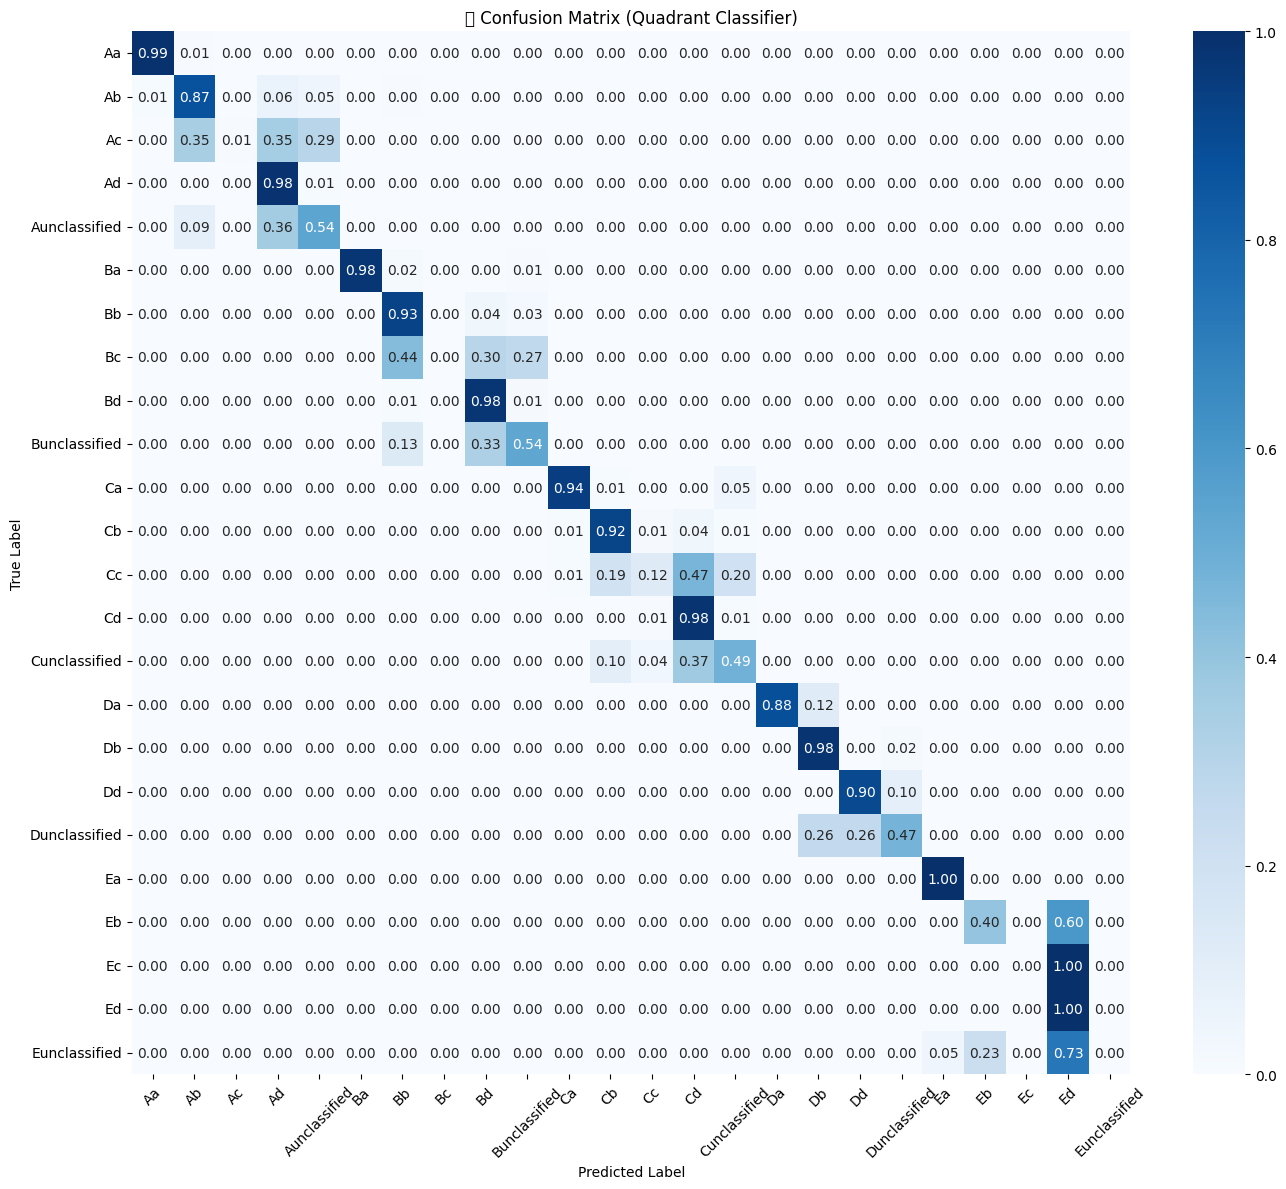

In [40]:
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('🎯 Confusion Matrix (Quadrant Classifier)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [53]:
df_all.head(10)

,symbol,time,trend_group,group,quadrant,close_price,EMA5,EMA15,EMA35,EMA89,EMA200,RSI,pe,pbv,dividendyield,marketcap,bvps
0,2S,2022-06-13,b,A,Ab,4.36,4.360000,4.360000,4.360000,4.360000,4.360000,NaN,35.88,0.7,4.3,1.407990e+09,3.64
1,2S,2022-06-14,d,A,Ad,4.32,4.346667,4.355000,4.357778,4.359111,4.359602,NaN,35.88,0.7,4.3,1.407990e+09,3.64
2,2S,2022-06-15,d,A,Ad,4.30,4.331111,4.348125,4.354568,4.357798,4.359009,NaN,35.88,0.7,4.3,1.407990e+09,3.64
3,2S,2022-06-16,d,A,Ad,4.22,4.294074,4.332109,4.347092,4.354735,4.357626,NaN,35.88,0.7,4.3,1.407990e+09,3.64
4,2S,2022-06-17,d,A,Ad,4.20,4.262716,4.315596,4.338920,4.351297,4.356057,NaN,35.88,0.7,4.3,1.407990e+09,3.64
5,2S,2022-06-20,d,A,Ad,4.20,4.241811,4.301146,4.331202,4.347935,4.354505,NaN,35.88,0.7,4.3,1.407990e+09,3.64
6,2S,2022-06-21,d,A,Ad,4.20,4.227874,4.288503,4.323913,4.344647,4.352967,NaN,35.88,0.7,4.3,1.407990e+09,3.64
7,2S,2022-06-22,d,A,Ad,4.20,4.218582,4.277440,4.317029,4.341433,4.351445,NaN,35.88,0.7,4.3,1.407990e+09,3.64
8,2S,2022-06-23,d,A,Ad,4.18,4.205722,4.265260,4.309417,4.337846,4.349739,NaN,35.88,0.7,4.3,1.407990e+09,3.64
9,2S,2022-06-24,d,A,Ad,4.16,4.190481,4.252103,4.301116,4.333893,4.347851,NaN,35.88,0.7,4.3,1.407990e+09,3.64
